In [1]:
!pip install nltk

In [2]:
import nltk

In [3]:
#nltk.download()

In [4]:
from nltk.corpus import wordnet
import os
import numpy as np
import pandas as pd

In [5]:
#directories
curr_dir = os.getcwd()
target_words_dir = 'Targets.txt'
target_txt = open(os.path.join(curr_dir,target_words_dir),"r")

def get_target_words(file_dir):
    target_txt = open(file_dir,"r")
    words = target_txt.readlines()
    return([word[:-1].lower() for word in words])

def get_dataframe(target_words):
    data = {"words":[],"description":[]}
    for word in target_words:
        try:
            synset = wordnet.synsets(word)         
            data["description"].append(synset[0].definition())
            data["words"].append(word)
        except:pass
    return pd.DataFrame(data)

In [6]:
target_words = np.array(get_target_words(target_words_dir))
data = get_dataframe(target_words)

In [7]:
data.head(4)

,words,description
0,kitty,the combined stakes of the betters
1,lookup,an operation that determines whether one or mo...
2,otiose,serving no useful purpose; having no excuse fo...
3,gallant,a man who is much concerned with his dress and...


In [126]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import tensorflow as tf

from nltk.corpus import stopwords  

In [9]:
class PreProcess:
    tokenizer = Tokenizer(oov_token="<OOV>")
    max_sequence_len = None
    def __init__(self,corpus):
        self.corpus = self.remove_stop_words(corpus)
        self.tokenizer.fit_on_texts(corpus)
        
    def remove_stop_words(self,data):
        stop_words = set(stopwords.words('english'))
        for i in range(len(data)):
            sent_lst = list(data[i].split(" "))
            sent_lst = filter(lambda x: x not in stop_words, sent_lst)
            data[i] = ' '.join([str(wrd) for wrd in sent_lst])
        return data
            
    def tokenize(self,data):
        data = self.remove_stop_words(data)
        seq = self.tokenizer.texts_to_sequences(data)
        if(self.max_sequence_len == None):self.max_sequence_len = max([len(x) for x in seq])        
        seq_padded = pad_sequences(seq,maxlen=self.max_sequence_len)
        return(seq_padded)
    
    def get_word_index(self):
        return(self.tokenizer.word_index)
    
    def get_seq_length(self):
        return self.max_sequence_len
    
    def get_vocab_length(self):
        return len(self.tokenizer.word_index) + 1
    

In [10]:
pre_pro_X = PreProcess(data['description'])
X = np.array(pre_pro_X.tokenize(data['description']))

max_seq_length = pre_pro_X.get_seq_length()
vocab_length = pre_pro_X.get_vocab_length()
print(max_seq_length)

36


In [11]:
#print(X.shape)

(21477, 36)


In [12]:
pre_pro_y = PreProcess(data['words'])
y = np.array(pre_pro_y.tokenize(data['words']))

total_target_words = pre_pro_y.get_vocab_length()
ys = tf.keras.utils.to_categorical(y, num_classes=total_target_words)


In [13]:
#print(ys.shape)

In [14]:
#ys

In [129]:
model = Sequential()
model.add(Embedding(vocab_length, 100, input_length=36))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(total_target_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="ADAM", metrics=['accuracy'])

In [ ]:
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X, ys, epochs=20, verbose=1)

Epoch 1/20


In [30]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

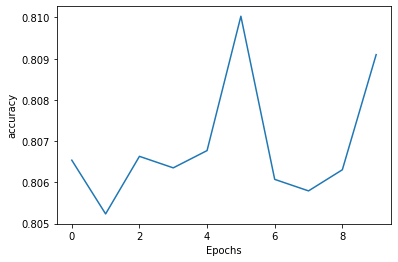

In [31]:
plot_graphs(history, 'accuracy')

In [117]:
test_description = "a German city; an industrial and commercial and financial center"
test_desc_encoded = pre_pro_X.tokenize([test_description])

In [118]:
test_desc_encoded

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  221,   15,  515,
         569, 1216,  141]])

In [119]:
predicted = np.argmax(model.predict(test_desc_encoded), axis=-1)

In [120]:
print(predicted)

[32085]


In [122]:
for word, index in pre_pro_y.tokenizer.word_index.items():
    if index == predicted[0]:
        print(word)
        break


baseline
